## Overview of TF-IDF

TF-IDF (short for term frequency–inverse document frequency) is a numerical statistic that is intended to reflect how important a word is to a document in a corpus.

The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word.

So, words that are common in every document, such as "this", "what", and "if", rank low even though they may appear many times, since they don’t mean much to that document in particular. However, if the word "Bug" appears many times in a document, while not appearing many times in others, it probably means that it’s very relevant.

## Ingest Data

* The tickets that were used to train model (created during the Code Sprint): "sample_data.json".
* The number of tickets used to train the model: 31794 tickets.
* No filtering was employed. Only the ticket text (tittle and body) were used.

**Data used for training:** all tickets (title and body text data) from "sample_data.json"
**Data used for keyword extraction:** first 500 tickets (only title and body text data) from "sample_data.json"

In [15]:
import pandas as pd
import json
import re

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [16]:
"""Get data for training"""

with open("data/sample_data1.json") as f:
  data = json.load(f)

tickets = {}
tickets = data['tickets']

with open('data/ticket_data.json', 'w') as json_file:
  json.dump(tickets, json_file)

"""
#Get first 500 tickets from all of the data for the keyword extraction
sample_tickets = []
sample_tickets =  tickets[0:500]

with open('data/sample_ticket_data.json', 'w') as json_file:
  json.dump(sample_tickets, json_file)
"""

"\n#Get first 500 tickets from all of the data for the keyword extraction\nsample_tickets = []\nsample_tickets =  tickets[0:500]\n\nwith open('data/sample_ticket_data.json', 'w') as json_file:\n  json.dump(sample_tickets, json_file)\n"

## Preprocessing and Feature Engineering steps

Inlcude the series of data cleaning steps that are included in your workflow

- stopword removal strategy
- tokenization/stemming strategy
- normalization

Steps:
1. read json into a dataframe
2. make all text lowercase
3. Remove all tags
4. Remove special characters and digits
5. Ignore words that appear in 85% of documents
6. Eliminate stopwords


### Data for training

In [17]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

In [18]:
# read json into a dataframe
df_idf = pd.read_json("data/ticket_data.json")

df_idf['text'] = df_idf['title'] + df_idf['content']
df_idf['text'] = df_idf['text'].apply(lambda x:pre_process(x))

"""
# print schema
print("Schema:\n\n",df_idf.dtypes)
print("Number of questions,columns=",df_idf.shape)

#show the first 'text'
df_idf['text'][0]
"""

'\n# print schema\nprint("Schema:\n\n",df_idf.dtypes)\nprint("Number of questions,columns=",df_idf.shape)\n\n#show the first \'text\'\ndf_idf[\'text\'][0]\n'

### Sample Data

In [19]:
# read test docs into a dataframe and concatenate title and body
df_test=pd.read_json("data/ticket_data.json")
df_test['text'] = df_test['title'] + df_test['content']
df_test['text'] =df_test['text'].apply(lambda x:pre_process(x))

# get test docs into a list
docs_test=df_test['text'].tolist()
docs_title=df_test['title'].tolist()
docs_body=df_test['content'].tolist()

## Tag lexicon definition description

The next step is to compute the tf-idf value for a given document in our test set by invoking tfidf_transformer.transform(...). This generates a vector of tf-idf scores. Next, we sort the words in the vector in descending order of tf-idf values and then iterate over to extract the top-n items with the corresponding feature names, In the example below, we are extracting keywords for the first document in our test set.

The sort_coo(...) method essentially sorts the values in the vector while preserving the column index. Once you have the column index then its really easy to look-up the corresponding word value as you would see in extract_topn_from_vector(...) where we do feature_vals.append(feature_names[idx]).

In [20]:
#get the text column 
docs=df_idf['text'].tolist()

#create a vocabulary of words, 
#ignore words that appear in 85% of documents
#eliminate stop words
cv=CountVectorizer(max_df=0.50,stop_words=stopwords.words('english'), min_df=1)
word_count_vector=cv.fit_transform(docs)

We can see that we have 31794 tickets with 45336 unique words in our dataset minus stopwords:

In [21]:
word_count_vector.shape

(31794, 45335)

#### Compute Inverse Document Frequency (IDF)

In [22]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

tfidf_transformer.idf_

array([ 9.57530485,  9.57530485, 10.26845204, ..., 10.67391714,
       10.67391714, 10.67391714])

In [23]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [24]:
# you only needs to do this once
feature_names=cv.get_feature_names()

In [41]:
# put the common code into several methods
def get_keywords(idx):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs_test[idx]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

def print_results(idx,keywords):
    # now print the results
    print("\n=====Title=====")
    print(docs_title[idx])
    print("\n=====Body=====")
    print(docs_body[idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k,keywords[k])

In [42]:
idx=1000

keywords=get_keywords(idx)
print_results(idx,keywords)


=====Title=====
when I click on one of my bookmarks  i get the following message:  The request did not specify a vaild virtual host, how do i fix

=====Body=====
<p>the problem.
</p>

===Keywords===
vaild 0.534
virtual 0.374
specify 0.366
host 0.354
request 0.288
following 0.239
fix 0.18
bookmarks 0.179
message 0.175
one 0.157


In [57]:
# go through all tickets one by one 
# 31794
tags_dict = {}
num_tags = 0

for idx in range(30000):
    keywords=get_keywords(idx)
    
    for k in keywords:
        if keywords[k] >= 0.2:            
            #check if this tag is already in the dictionary
            if k in tags_dict:
                tags_dict[k] += 1
            else:
                tags_dict[k] = 1
                num_tags += 1

print(len(tags_dict))

with open('tf-idf_ALL_tags.txt', 'w') as file:
    file.write(json.dumps(tags_dict))
    
usefull_tag_dict = {}

for key, value in tags_dict.items():
    if value > 10:
        usefull_tag_dict[key] = value

print(len(usefull_tag_dict))
        
with open('tf-idf_tags.txt', 'w') as file:
    file.write(json.dumps(usefull_tag_dict))


# create tags for them
# add their tags that are >= 0.2 to the distionary
# if there is already a key with tha same tag increase value by 1



26472
2769


In [71]:
import operator

sorted_list = sorted(usefull_tag_dict.items(), key=operator.itemgetter(1), reverse = True)

print("{:<20} {:<7}".format('tag', 'count'))

for k, v in sorted_list:
    print("{:<20} {:<7}".format(k, v))

tag                  count  
bookmarks            962    
page                 898    
tab                  892    
open                 882    
search               802    
ff                   778    
crashes              736    
download             723    
tabs                 694    
version              687    
google               672    
new                  656    
bar                  653    
update               604    
window               583    
flash                578    
yahoo                558    
email                532    
file                 512    
toolbar              498    
mail                 460    
video                450    
add                  446    
site                 420    
history              416    
address              406    
error                405    
click                401    
password             399    
bookmark             398    
screen               395    
home                 387    
button               378    
load          

house                22     
ticked               22     
xx                   22     
kept                 22     
provided             22     
bunch                22     
reads                22     
beginning            22     
processor            22     
vpn                  22     
uploaded             22     
stated               22     
archive              22     
asap                 22     
mine                 22     
written              22     
similar              22     
popped               22     
instantly            22     
stable               22     
vanished             22     
pad                  22     
refreshing           22     
query                22     
itunes               22     
gov                  22     
interface            22     
indicates            22     
miss                 22     
digital              22     
self                 22     
affected             22     
formatted            22     
jumps                22     
strip         

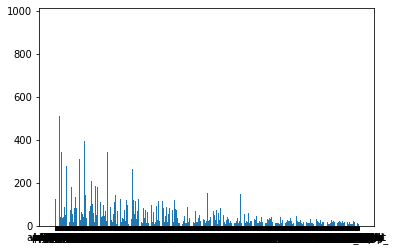

In [63]:
import matplotlib.pyplot as plt

dict_graph = usefull_tag_dict
#dict_graph = sorted(usefull_tag_dict.items(), key=lambda x: x[1], reverse=True)

plt.bar(range(len(dict_graph)), list(dict_graph.values()), align='center')
plt.xticks(range(len(dict_graph)), list(dict_graph.keys()))
plt.savefig('tags.png')

### Classifier/Annontator Training step

Describe the model and the model training step

- Include a description the feature space used
- Include a description of the selected classification or annotation model
- Describe the training process and expected runtime for training

In [27]:
"""code that executes model training step"""

'code that executes model training step'

### Classifier/Annotator Testing step

Describe the testing of the trained model's performace against a defined test set.

- Include the raw performance
- Include the source of ground truth for the evaluation
- Include figures for FP/FN/ROC type metrics describing the model performance.

In [28]:
"""code that executes the model testing step"""

'code that executes the model testing step'

### Interpretation
Sumamrize the model performance and findings related to specific misclassified items also a breif description of the findings as they correpsonde to generalizability.